In [ ]:
!pip install torch

In [10]:
%pip install opencv-python-headless

In [11]:
import pandas as pd
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from xml.etree import ElementTree
from PIL import Image

In [2]:
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

# load the facemask dataset**

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
%cd  /content/drive/MyDrive

/content/drive/MyDrive


In [23]:
%cd /content/drive/MyDrive/facemask_project/demo/demo_files/

/content/drive/MyDrive/facemask_project/demo/demo_files


In [ ]:
# run the code below onlly once!

zip_file_path = 'face-mask-detection.zip'

# Unzip the file in the current directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('.')

print("Unzipping completed.")

Unzipping completed.


In [15]:
ls

 annotations/     face-mask-detection.zip   main_cnn.ipynb  'Untitled5 (3).ipynb'
 dataset_files/   images/                   main.ipynb       yolo11n.pt
 data.yaml        labels.csv                runs/            yolov8n.pt


# 1. Preprocess the data

In [24]:
annotations_directory = '/content/drive/MyDrive/facemask_project/demo/demo_files/annotations'
images_directory = '/content/drive/MyDrive/facemask_project/demo/demo_files/images'

**content of annotations and images folder**:

annotations cntains metadata about the images stored in the images folder. This metadata can include information such as labels, bounding boxes, segmentation masks, or any other relevant data that describes the content of the images.

The images folder contains the actual image files that are being annotated.

In [25]:
information = {'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'label': [], 'file': [], 'width': [], 'height': []}

for annotation in glob.glob(annotations_directory + '/*.xml'):
    tree = ElementTree.parse(annotation)

    for element in tree.iter():
        if 'size' in element.tag:
            for attribute in list(element):
                if 'width' in attribute.tag:
                    width = int(round(float(attribute.text)))
                if 'height' in attribute.tag:
                    height = int(round(float(attribute.text)))

        if 'object' in element.tag:
            for attribute in list(element):

                if 'name' in attribute.tag:
                    name = attribute.text
                    information['label'] += [name]
                    information['width'] += [width]
                    information['height'] += [height]
                    information['file'] += [annotation.split('/')[-1][0:-4]]

                if 'bndbox' in attribute.tag:
                    for dimension in list(attribute):
                        if 'xmin' in dimension.tag:
                            xmin = int(round(float(dimension.text)))
                            information['xmin'] += [xmin]
                        if 'ymin' in dimension.tag:
                            ymin = int(round(float(dimension.text)))
                            information['ymin'] += [ymin]
                        if 'xmax' in dimension.tag:
                            xmax = int(round(float(dimension.text)))
                            information['xmax'] += [xmax]
                        if 'ymax' in dimension.tag:
                            ymax = int(round(float(dimension.text)))
                            information['ymax'] += [ymax]

code above :
xmin, ymin, xmax, ymax: Bounding box coordinates of objects

label: Object class

file: Image filename

width, height: Image dimensions

this will loops through XML files in the specified directory, extracts the necessary data from <size>, <object>, and <bndbox> tags, and appends the information to the information dictionary

In [26]:
#Create DataFrame from the information dictionary
annotations_info_df = pd.DataFrame(information)

In [27]:
#View the first few rows of the DataFrame
annotations_info_df.head()

,xmin,ymin,xmax,ymax,label,file,width,height
0,79,105,109,142,without_mask,maksssksksss0,512,366
1,185,100,226,144,with_mask,maksssksksss0,512,366
2,325,90,360,141,without_mask,maksssksksss0,512,366
3,321,34,354,69,with_mask,maksssksksss1,400,156
4,224,38,261,73,with_mask,maksssksksss1,400,156


In [28]:
annotations_info_df.head(10)

,xmin,ymin,xmax,ymax,label,file,width,height
0,79,105,109,142,without_mask,maksssksksss0,512,366
1,185,100,226,144,with_mask,maksssksksss0,512,366
2,325,90,360,141,without_mask,maksssksksss0,512,366
3,321,34,354,69,with_mask,maksssksksss1,400,156
4,224,38,261,73,with_mask,maksssksksss1,400,156
5,299,58,315,81,with_mask,maksssksksss1,400,156
6,143,74,174,115,with_mask,maksssksksss1,400,156
7,74,69,95,99,with_mask,maksssksksss1,400,156
8,191,67,221,93,with_mask,maksssksksss1,400,156
9,21,73,44,93,with_mask,maksssksksss1,400,156


In [29]:
# The label for the "incorrect mask" has been updated to mask_incorrectly_worn
annotations_info_df['annotation_file'] = annotations_info_df['file'] + '.xml'
annotations_info_df['image_file'] = annotations_info_df['file'] + '.png'
annotations_info_df.loc[annotations_info_df['label'] == 'mask_weared_incorrect', 'label'] = 'mask_incorrectly_worn'

Display the image (reder_image function)

In [30]:
def render_image(image_path):
    # Read the image from the provided path
    image = cv2.imread(image_path)

    # Extract the image file name from the image path
    img = image_path.split('/')[-1]

    # Convert the image from BGR to RGB format (since OpenCV uses BGR and matplotlib uses RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize an empty list to store the bounding box coordinates
    bound_box = []

    # Loop through all rows in the DataFrame where the image_file column matches the current image
    for i in annotations_info_df[annotations_info_df['image_file'] == img].index:
        # Extract the bounding box coordinates for the object
        (xmin, ymin, xmax, ymax) = (
            annotations_info_df.loc[i].xmin, annotations_info_df.loc[i].ymin,
            annotations_info_df.loc[i].xmax, annotations_info_df.loc[i].ymax
        )

        # Append the bounding box coordinates to the bound_box list
        bound_box.append((xmin, ymin, xmax, ymax))

        # Check the label of the object and draw the corresponding rectangle and label
        if annotations_info_df.loc[i].label == 'with_mask':
            # Draw a green rectangle for objects with a mask
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 200, 0), 2)
            cv2.putText(image, org=(xmin - 8, ymin - 8), text="Mask",
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 200, 0))

        elif annotations_info_df.loc[i].label == 'mask_incorrectly_worn':
            # Draw a yellow rectangle for objects with a mask incorrectly worn
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 255, 0), 2)
            cv2.putText(image, org=(xmin - 8, ymin - 3), text="Incorrect",
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255, 255, 0))

        else:
            # Draw a red rectangle for objects with no mask
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (200, 0, 0), 2)
            cv2.putText(image, org=(xmin - 8, ymin - 3), text="No mask",
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(200, 0, 0))

    # Display the image with the bounding boxes using matplotlib
    plt.figure(figsize=(5, 5))  # Set the figure size for displaying
    plt.imshow(image)  # Show the image
    plt.show()  # Display the image

    # Return the list of bounding boxes and the modified image
    return bound_box, image


Now we will return the list of unique image file names (image_file) from the annotations_info_df DataFram
For each image, it checks if there are exactly two annotations associated with it
If an image has exactly two annotations we simply add the image file name to the list of images_with_two_annotations

In [32]:
images_with_2=[]
for _ in annotations_info_df['image_file'].value_counts().index:
    if annotations_info_df[annotations_info_df['image_file']==_].shape[0]==2:
        images_with_2.append(_)


print('`images_with_2` contains the names of all images that have exactly 2 annotations (people): ',len(images_with_2))


`images_with_2` contains the names of all images that have exactly 2 annotations (people):  100


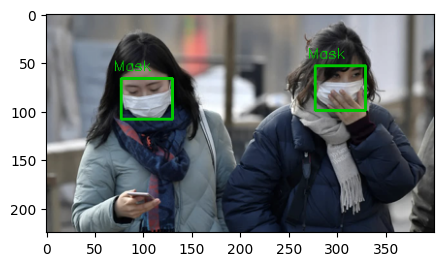

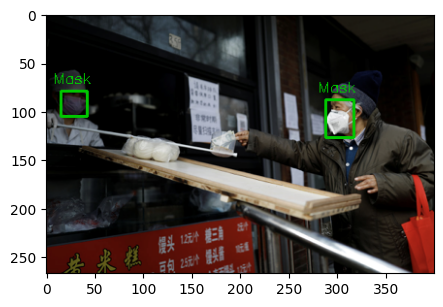

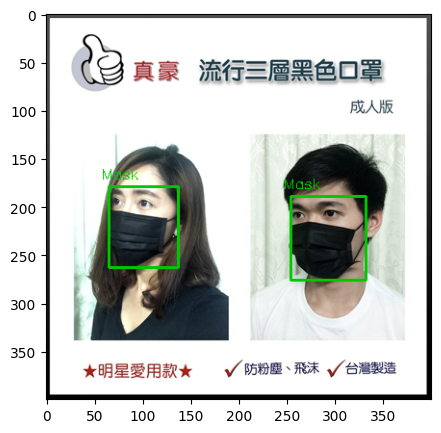

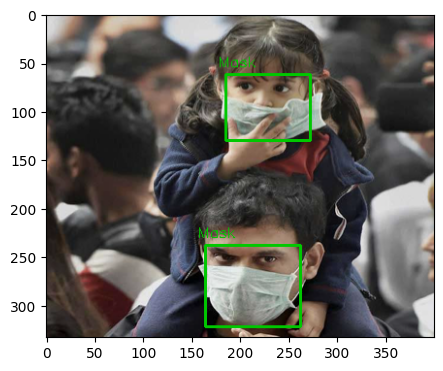

In [33]:
for i in images_with_2[5:9]: #from index 5 to 8 (inclusive)
    render_image(os.path.join(images_directory,i))  # Call the render_image function to display the image and its bounding boxes

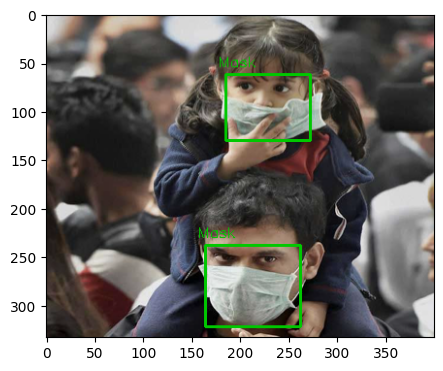

[(185, 62, 272, 130), (164, 238, 262, 322)]

In [34]:
bound_box,image=render_image(os.path.join(images_directory,i))
bound_box

bound_box stores the list of bounding box coordinates. Since you mentioned that each image contains two people, bound_box will store two sets of coordinates, corresponding to the two bounding boxes in the image.

meaning the result Result:
bound_box will be a list of two tuples, each representing the bounding box of one person detected in particular pic

Cropping image

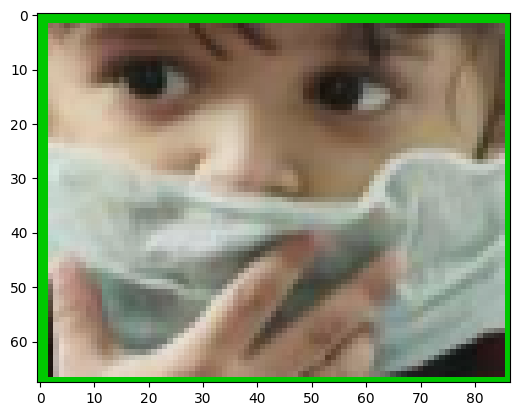

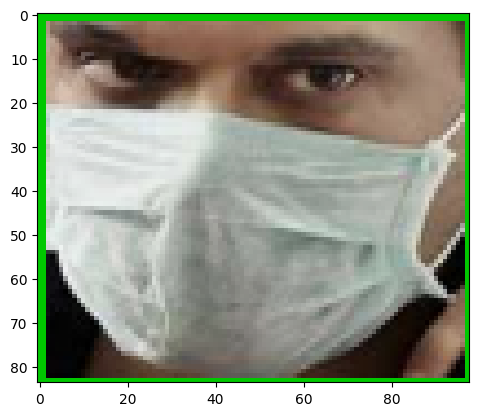

In [37]:
for i in bound_box:
    # Crop the image using the bounding box coordinates ymin:ymax, xmin:xmax
    cropped = image[i[1]:i[3], i[0]:i[2]]

    # Display the cropped image
    plt.imshow(cropped)
    plt.show()

  The first cropped image will show the first person
  The second cropped image will show the second person

In [38]:
!pwd

/content/drive/MyDrive/facemask_project/demo/demo_files


In [39]:
# Create the new directory to store cropped images
directory = 'cropped_images'
parent_directory = '/content/drive/MyDrive/facemask_project/demo/demo_files'
path = os.path.join(parent_directory, directory)
os.mkdir(path)

In [40]:
annotations_info_df['cropped_image_file'] = annotations_info_df['file']
annotations_info_df

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file,cropped_image_file
0,79,105,109,142,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0
1,185,100,226,144,with_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0
2,325,90,360,141,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0
3,321,34,354,69,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1
4,224,38,261,73,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1
...,...,...,...,...,...,...,...,...,...,...,...
4067,263,62,287,85,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png,maksssksksss98
4068,344,80,377,106,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png,maksssksksss98
4069,181,54,273,162,mask_incorrectly_worn,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png,maksssksksss99
4070,99,87,176,165,with_mask,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png,maksssksksss99


each row of the annotations_info_df will have a new column 'cropped_image_file' which will store the base filenames of the images

In [49]:
ls

 annotations/      data.yaml                 labels.csv       runs/                  yolov8n.pt
 cropped_images/   face-mask-detection.zip   main_cnn.ipynb  'Untitled5 (3).ipynb'
 dataset_files/    images/                   main.ipynb       yolo11n.pt


In [50]:
# Loop through each row in the DataFrame
for i in range(len(annotations_info_df)):
    # Construct the image file path
    image_filepath = '/content/drive/MyDrive/facemask_project/demo/demo_files/images/' + annotations_info_df['image_file'].iloc[i]

    # Read the image using OpenCV
    image = cv2.imread(image_filepath)

    # Check if the image was loaded correctly
    if image is None:
        print(f"Error reading image: {image_filepath}")
        continue  # Skip to the next iteration if the image wasn't loaded

    # Update the cropped image file name
    annotations_info_df.loc[i, 'cropped_image_file'] = annotations_info_df.loc[i, 'cropped_image_file'] + '-' + str(i) + '.png'
    cropped_image_filename = annotations_info_df.loc[i, 'cropped_image_file']

    # Get bounding box coordinates
    xmin = annotations_info_df['xmin'].iloc[i]
    ymin = annotations_info_df['ymin'].iloc[i]
    xmax = annotations_info_df['xmax'].iloc[i]
    ymax = annotations_info_df['ymax'].iloc[i]

    # Crop the image
    cropped_image = image[ymin:ymax, xmin:xmax]

    # Create the path for saving the cropped image
    cropped_image_directory = os.path.join('./cropped_images', cropped_image_filename)

    # Save the cropped image
    cv2.imwrite(cropped_image_directory, cropped_image)

In [51]:
annotations_info_df

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file,cropped_image_file
0,79,105,109,142,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0-0.png-0.png-0.png-0.png-0.png-0.png
1,185,100,226,144,with_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0-1.png-1.png-1.png
2,325,90,360,141,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0-2.png-2.png-2.png
3,321,34,354,69,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1-3.png-3.png-3.png
4,224,38,261,73,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1-4.png-4.png-4.png
...,...,...,...,...,...,...,...,...,...,...,...
4067,263,62,287,85,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png,maksssksksss98-4067.png
4068,344,80,377,106,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png,maksssksksss98-4068.png
4069,181,54,273,162,mask_incorrectly_worn,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png,maksssksksss99-4069.png
4070,99,87,176,165,with_mask,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png,maksssksksss99-4070.png


In [52]:
classes=annotations_info_df['label'].unique()
classes


array(['without_mask', 'with_mask', 'mask_incorrectly_worn'], dtype=object)

In [53]:
# we need this to separate the labels from the rest of your data
labels=annotations_info_df['label']
annotations_info_df.drop(['label'],axis=1,inplace=True)

#Training

In [54]:
from sklearn.model_selection import train_test_split
# Split into training and testing sets (75% training, 25% testing
X_train,X_test,Y_train,Y_test=train_test_split(annotations_info_df,labels,test_size=0.25,stratify=labels,random_state=42)

In [57]:
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print("\nValue count",Y_train.value_counts())

Training set size: 3054
Testing set size: 1018

Value count label
with_mask                2424
without_mask              538
mask_incorrectly_worn      92
Name: count, dtype: int64


In [58]:
image_width = []
image_height = []
for i in range(len(X_train)):
    cropped_image_path = './cropped_images/' + X_train['cropped_image_file'].iloc[i] # Get the image path from the cropped_image_file column
    cropped_image = cv2.imread(cropped_image_path)
    image_width.append(cropped_image.shape[0])
    image_height.append(cropped_image.shape[1])

print('IMAGE WIDTH')
print(f'Min: {min(image_width)}')
print(f'Max: {max(image_width)}')
print(f'Mean: {np.mean(image_width)}')
print(f'Median: {np.median(image_width)}')
print('IMAGE HEIGHT')
print(f'Min: {min(image_height)}')
print(f'Max: {max(image_height)}')
print(f'Mean: {np.mean(image_height)}')
print(f'Median: {np.median(image_height)}')

IMAGE WIDTH
Min: 2
Max: 340
Mean: 35.384086444007856
Median: 24.0
IMAGE HEIGHT
Min: 1
Max: 317
Mean: 31.467910936476752
Median: 22.0


 now we need to resizing images to fixed size before feeding them into the Convolutional Neural Network (CNN)

In [59]:
image_target_size = (int(60), int(60))
image_target_size

(60, 60)

In [60]:
# Reattaching the labels
X_train['label']=Y_train
X_test['label']=Y_test

In [62]:
X_train

,xmin,ymin,xmax,ymax,file,width,height,annotation_file,image_file,cropped_image_file,label
2649,175,68,191,87,maksssksksss595,400,267,maksssksksss595.xml,maksssksksss595.png,maksssksksss595-2649.png,with_mask
3609,83,43,119,86,maksssksksss771,400,267,maksssksksss771.xml,maksssksksss771.png,maksssksksss771-3609.png,with_mask
349,15,111,114,219,maksssksksss165,450,463,maksssksksss165.xml,maksssksksss165.png,maksssksksss165-349.png,with_mask
3141,80,55,102,80,maksssksksss684,400,269,maksssksksss684.xml,maksssksksss684.png,maksssksksss684-3141.png,with_mask
987,235,7,245,16,maksssksksss280,400,267,maksssksksss280.xml,maksssksksss280.png,maksssksksss280-987.png,with_mask
...,...,...,...,...,...,...,...,...,...,...,...
696,203,103,216,115,maksssksksss240,400,245,maksssksksss240.xml,maksssksksss240.png,maksssksksss240-696.png,with_mask
3617,218,61,241,85,maksssksksss773,400,274,maksssksksss773.xml,maksssksksss773.png,maksssksksss773-3617.png,with_mask
356,351,204,372,226,maksssksksss166,400,267,maksssksksss166.xml,maksssksksss166.png,maksssksksss166-356.png,with_mask
1578,106,70,129,98,maksssksksss399,400,267,maksssksksss399.xml,maksssksksss399.png,maksssksksss399-1578.png,with_mask


# augmentation

In [65]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00


In [66]:
from keras_preprocessing.image import ImageDataGenerator

In [67]:
#improve the model's robustness and generalization
train_image_generator = ImageDataGenerator(rescale=1.0 / 255,  # pixel values of the images from the range [0, 255]
                                           horizontal_flip=True,    #(left to right)
                                           zoom_range=0.1,
                                           shear_range=0.2,
                                           width_shift_range=0.1,   #horizontally by 10%
                                           height_shift_range=0.1,  #vertically by 10%
                                           rotation_range=4,
                                           vertical_flip=False)


train_generator = train_image_generator.flow_from_dataframe(
    dataframe = X_train,
    directory = './cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    subset = 'training',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',       #one-hot encoding
    target_size = image_target_size
)

Found 3054 validated image filenames belonging to 3 classes.


In [68]:
class_ind = train_generator.class_indices
class_ind

{'mask_incorrectly_worn': 0, 'with_mask': 1, 'without_mask': 2}

In [69]:
# Test generator setup
test_image_generator = ImageDataGenerator(rescale = 1. / 255.)

test_generator = train_image_generator.flow_from_dataframe(
    dataframe = X_test,
    directory = './cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

Found 1018 validated image filenames belonging to 3 classes.


In [70]:
test_generator.class_indices

{'mask_incorrectly_worn': 0, 'with_mask': 1, 'without_mask': 2}

# 3. build a Convolutional Neural Network (CNN) model

this is the architecture with multiple convolutional layers, batch normalization, max pooling, dense layers, dropout, and a softmax output for(((multi-class classification)))

In [71]:
def my_model():
    inputs = keras.Input(shape=(60,60, 3))
    x = layers.Conv2D(32, 3)(inputs)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3)(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3)(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x) # used to introduce non-linearity after each convolutional and fully connected layer
    x = layers.Dropout(0.5)(x)              # prevent overfitting
    x = layers.Dense(64, activation="relu")(x)

    outputs = layers.Dense(3,activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [72]:
model=my_model()
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 60, 60, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 58, 58, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 58, 58, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 58, 58, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 29, 29, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 27, 27, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 11, 11, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 11, 11, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,965,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,075,971 (15.55 MB)

 Trainable params: 4,075,523 (15.55 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [74]:
from tensorflow.keras.utils import plot_model

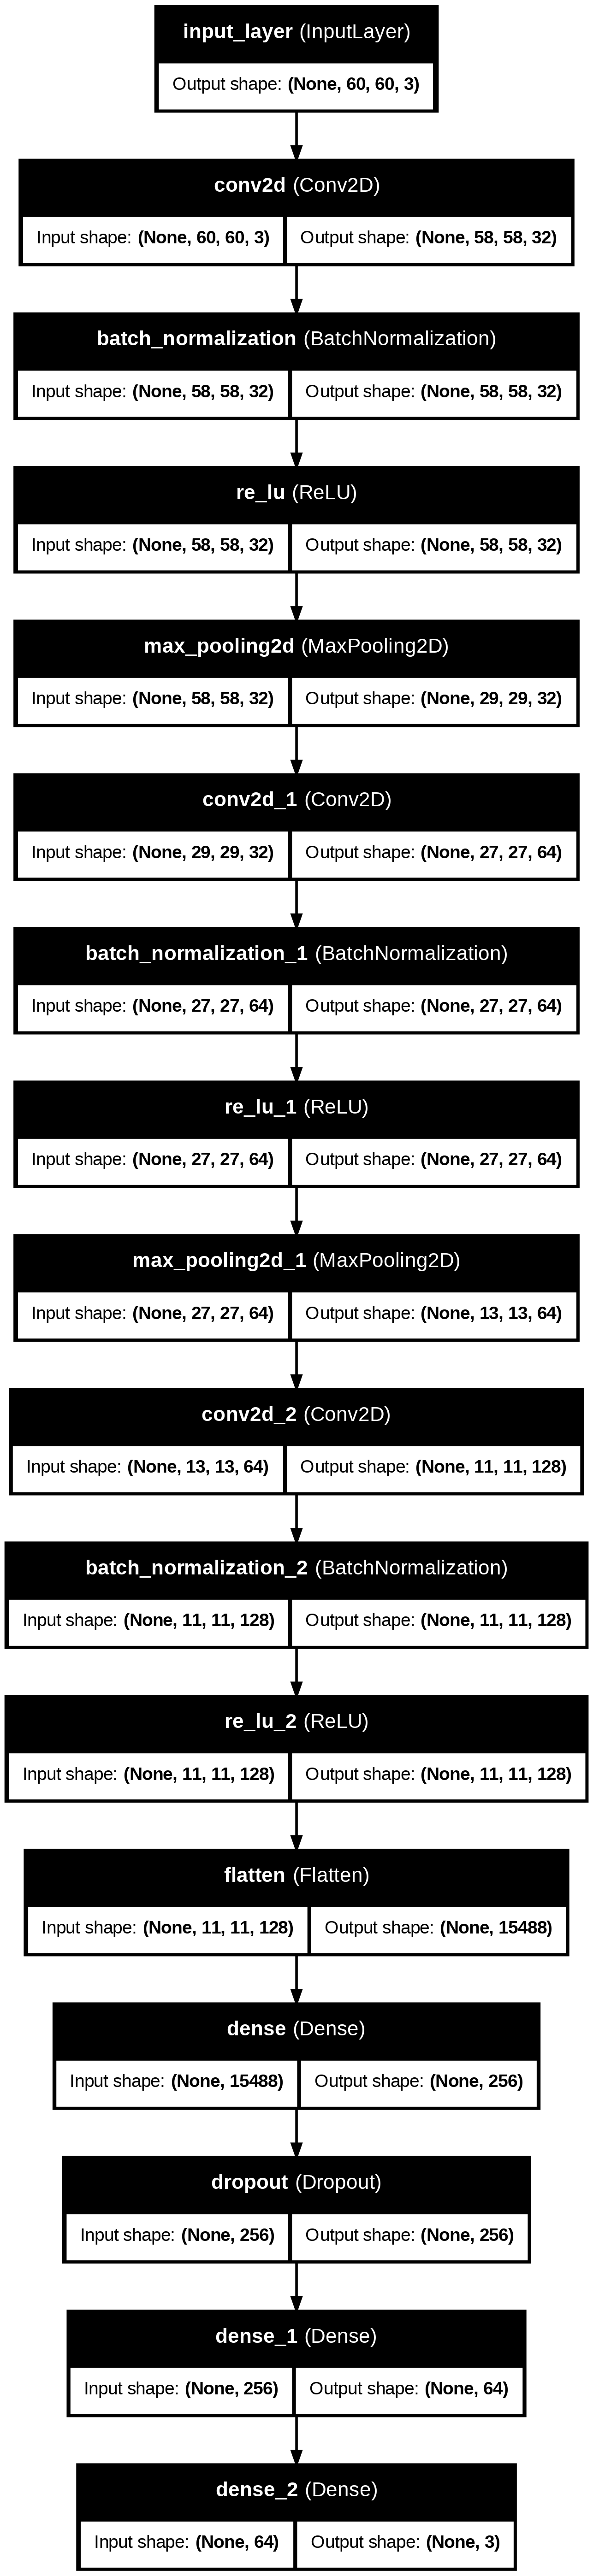

In [75]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [77]:
# Because its a multi-class classification problems we should set the loss to 'categorical_crossentropy'
model.compile(loss = 'categorical_crossentropy',
                optimizer = keras.optimizers.Adam(learning_rate = 0.001),
                metrics = ['accuracy'])

cnn_history_1 = model.fit(train_generator, epochs = 10, steps_per_epoch = len(train_generator),
                     validation_data = test_generator, validation_steps = len(test_generator))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 222ms/step - accuracy: 0.8084 - loss: 1.1696 - val_accuracy: 0.8202 - val_loss: 0.5748
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 185ms/step - accuracy: 0.8918 - loss: 0.4650 - val_accuracy: 0.7760 - val_loss: 0.6781
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 174ms/step - accuracy: 0.9109 - loss: 0.3095 - val_accuracy: 0.8527 - val_loss: 0.4219
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 174ms/step - accuracy: 0.9168 - loss: 0.2943 - val_accuracy: 0.8821 - val_loss: 0.3159
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - accuracy: 0.9281 - loss: 0.2385 - val_accuracy: 0.9067 - val_loss: 0.2714
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - accuracy: 0.9308 - loss: 0.2265 - val_accuracy: 0.9293 - val_loss: 0.1974
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 0.9231 - loss: 0.2382 - val_accuracy: 0.9391 - val_loss: 0.1948
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - accuracy: 0.9368 - loss: 0.2046 - val_accu

In [78]:
# accuracy : percentage of correctly predicted instances out of all predictions made

The model is being trained with categorical cross-entropy loss and the Adam optimizer

It will run for 10 epochs, using  training and validation data generators

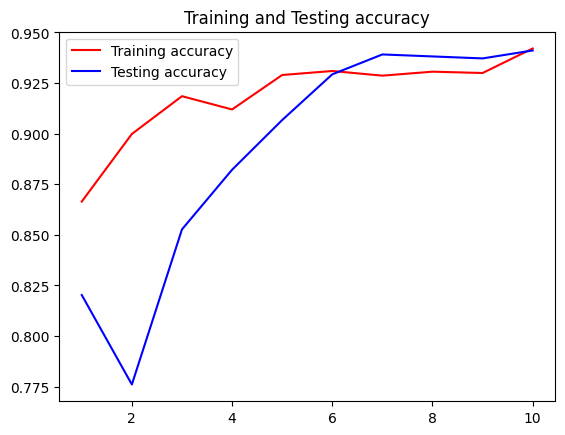

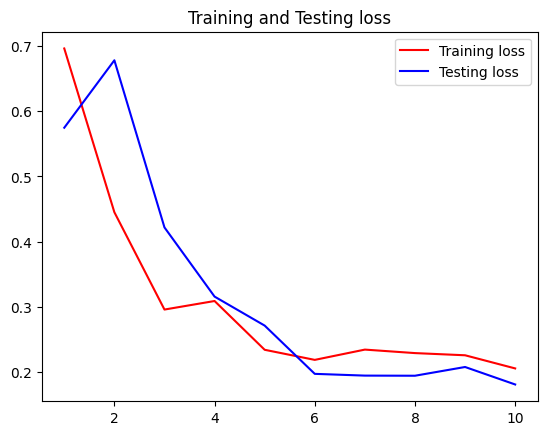

In [79]:
accuracy = cnn_history_1.history["accuracy"]
val_accuracy = cnn_history_1.history["val_accuracy"]
loss = cnn_history_1.history["loss"]
val_loss = cnn_history_1.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# Plot training and testing accuracy
plt.plot(epochs, accuracy, "r", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Testing accuracy")
plt.title("Training and Testing accuracy")
plt.legend()

# Plot training and testing loss
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Testing loss")
plt.title("Training and Testing loss")
plt.legend()

# Display the plots
plt.show()


# Evaluate your model


Report metrics: accuracy, precision, recall, and F1-score.

Visualize the confusion matrix to analyze performance across different classes.

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step
Accuracy: 0.6728880157170923
Precision: 0.3194444444444444
Recall: 0.32753009937865296
F1-score: 0.3234366335055377


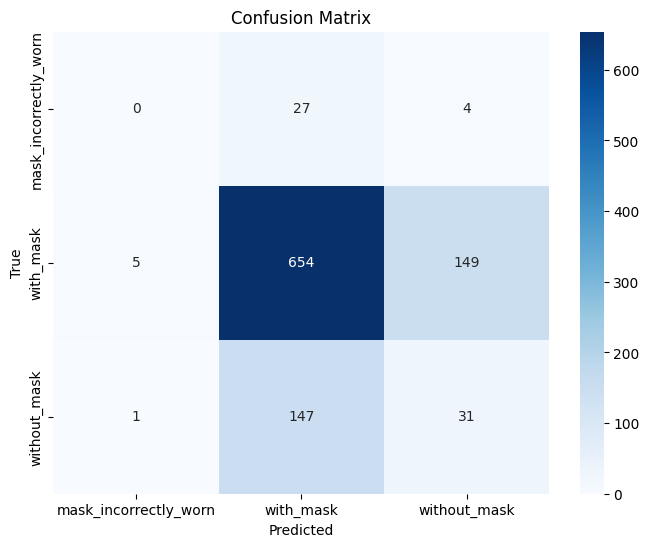

In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict on the test set
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = test_generator.classes

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro') # Use macro averaging for multi-class
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(class_ind.keys()), yticklabels=list(class_ind.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Saving model

In [82]:
model.save('face_mask_detection_cnn.h5')

# extra-validate using img unknown to the dataset

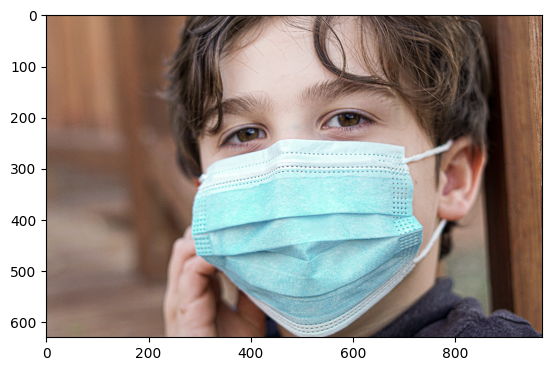

In [85]:
children_path = '/content/drive/MyDrive/facemask_project/demo/demo_files/children/child_with_mask.jpg'
image=cv2.imread(children_path)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

# normalizes the pixel values of the image

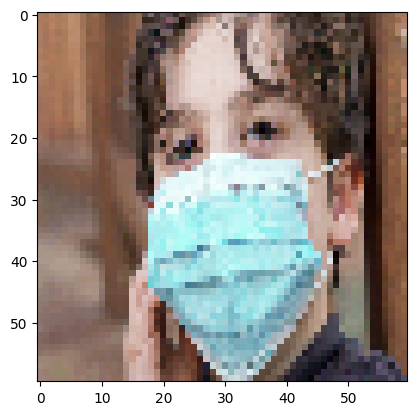

In [86]:
bigger = cv2.resize(image, (60,60))
plt.imshow(bigger)


In [87]:

bigger=bigger/255
bigger=bigger.reshape(1,60,60,3)
class_ind

{'mask_incorrectly_worn': 0, 'with_mask': 1, 'without_mask': 2}

# predicted probabilities

In [88]:
pred_val=model.predict(bigger)
pred_val

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


array([[2.5907278e-04, 9.9974090e-01, 1.7930618e-13]], dtype=float32)

Incorrectly Worn: 0.00, Mask On: 1.00, without Mask: 0.00


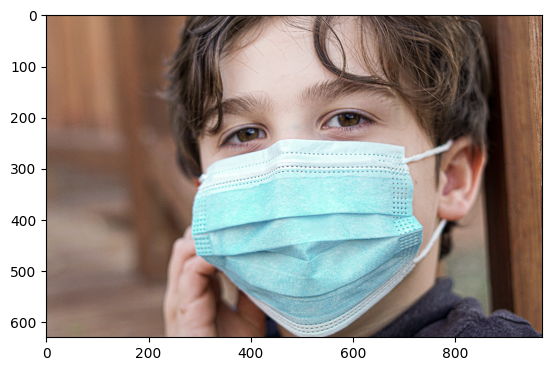

In [89]:
import matplotlib.pyplot as plt

plt.imshow(image)

# Print the predicted probabilities for each class
print("Incorrectly Worn: {:.2f}, Mask On: {:.2f}, without Mask: {:.2f}".format(pred_val[0][0],
                                                              pred_val[0][1],
                                                              pred_val[0][2]))


In [90]:
pred_val=np.argmax(model.predict(bigger))

y_pred=[]
for i,j in class_ind.items():
    if pred_val==j:
        y_pred.append(i)

print('classification result ', y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
classification result  ['with_mask']
